In [1]:
from __future__ import print_function
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import time
import matplotlib.dates
from matplotlib.dates import DateFormatter
import math
import torch
import torch.nn as nn
import  torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.nn.parameter import Parameter
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.init import kaiming_normal_
import keras
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using TensorFlow backend.


In [2]:
sns.set()
tf.random.set_random_seed(1234)

df = pd.read_csv('D:\SPY(7).csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-14,256.859985,258.299988,256.410004,257.399994,252.616516,70908200
1,2019-01-15,257.820007,260.700012,257.809998,260.350006,255.511658,85208300
2,2019-01-16,260.829987,261.970001,260.600006,260.980011,256.129944,77636700
3,2019-01-17,260.010010,263.920013,259.959991,262.959991,258.073151,96118400
4,2019-01-18,264.980011,266.980011,263.000000,266.459991,261.508118,127900300


In [3]:
df = df.values[:, 1:5]
print(df.shape)

(253, 4)


In [4]:
print(df.iloc[:, 4:5])

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [39]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Close index
df_log = pd.DataFrame(df_log)

print(minmax)
print(df_log)
df_log.head()

MinMaxScaler(copy=True, feature_range=(0, 1))
            0
0    0.000000
1    0.041814
2    0.050744
3    0.078809
4    0.128419
..        ...
248  0.950390
249  0.981573
250  0.968249
251  1.000000
252  0.992487

[253 rows x 1 columns]


,0
0,0.000000
1,0.041814
2,0.050744
3,0.078809
4,0.128419


In [5]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])


def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta


def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x = tf.layers.conv1d(inputs=tf.concat([pad, x, pad], 1),
                         filters=hidden_dim,
                         kernel_size=kernel_size,
                         dilation_rate=dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x


class Model:
    def __init__(
            self,
            learning_rate,
            num_layers,
            size,
            size_layer,
            output_size,
            kernel_size=3,
            n_attn_heads=16,
            dropout=0.9,
    ):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.layers.dense(self.X, size_layer)
        encoder_embedded += position_encoding(encoder_embedded)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.variable_scope('block_%d' % i):
                encoder_embedded += cnn_block(encoder_embedded, dilation_rate,
                                              pad_sz, size_layer, kernel_size)

        encoder_output, output_memory = encoder_embedded, encoder_embedded + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.variable_scope('decode_%d' % i):
                attn_res = h = cnn_block(encoder_embedded, dilation_rate,
                                         pad_sz, size_layer, kernel_size)

            C = []
            for j in range(n_attn_heads):
                h_ = tf.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, keep_prob=dropout)
            encoder_embedded += h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost)
        

        
        

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100


def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [6]:
test_size = 30
future_day = test_size
simulation_size = 5
num_layers = 1
size_layer = 128
timestamp = test_size
epoch = 150
dropout_rate = 0.8
learning_rate = 5e-4

df_train = df_log
df.shape, df_train.shape

((253, 7), (253, 1))

In [7]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1],
        dropout=dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k: index, :].values, axis=0
            )
            batch_y = df_train.iloc[k + 1: index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict={modelnn.X: batch_x, modelnn.Y: batch_y},
            )
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict={
                modelnn.X: np.expand_dims(
                    df_train.iloc[k: k + timestamp], axis=0
                )
            },
        )
        output_predict[k + 1: k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict={
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis=0)
            },
        )
        output_predict[upper_b + 1: df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict={
                modelnn.X: np.expand_dims(o, axis=0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    

    return deep_future


In [8]:
results = []
for i in range(simulation_size):
    print('simulation %d' % (i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s, acc=97.6, cost=0.00133]


simulation 2


C:\Users\synar\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|████████████████████████████████████████████| 150/150 [00:37<00:00,  3.98it/s, acc=97.5, cost=0.00154]


simulation 3


C:\Users\synar\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|████████████████████████████████████████████| 150/150 [00:38<00:00,  3.89it/s, acc=97.7, cost=0.00127]


simulation 4


C:\Users\synar\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|████████████████████████████████████████████| 150/150 [00:36<00:00,  4.07it/s, acc=97.3, cost=0.00194]


simulation 5


C:\Users\synar\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|███████████████████████████████████████████| 150/150 [00:37<00:00,  3.99it/s, acc=98.2, cost=0.000708]


In [9]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days=1))
date_ori = pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()
date_ori[-5:]

['2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13']

In [10]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

5

In [11]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]
Fcast_avg = ([r for r in accepted_results])

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


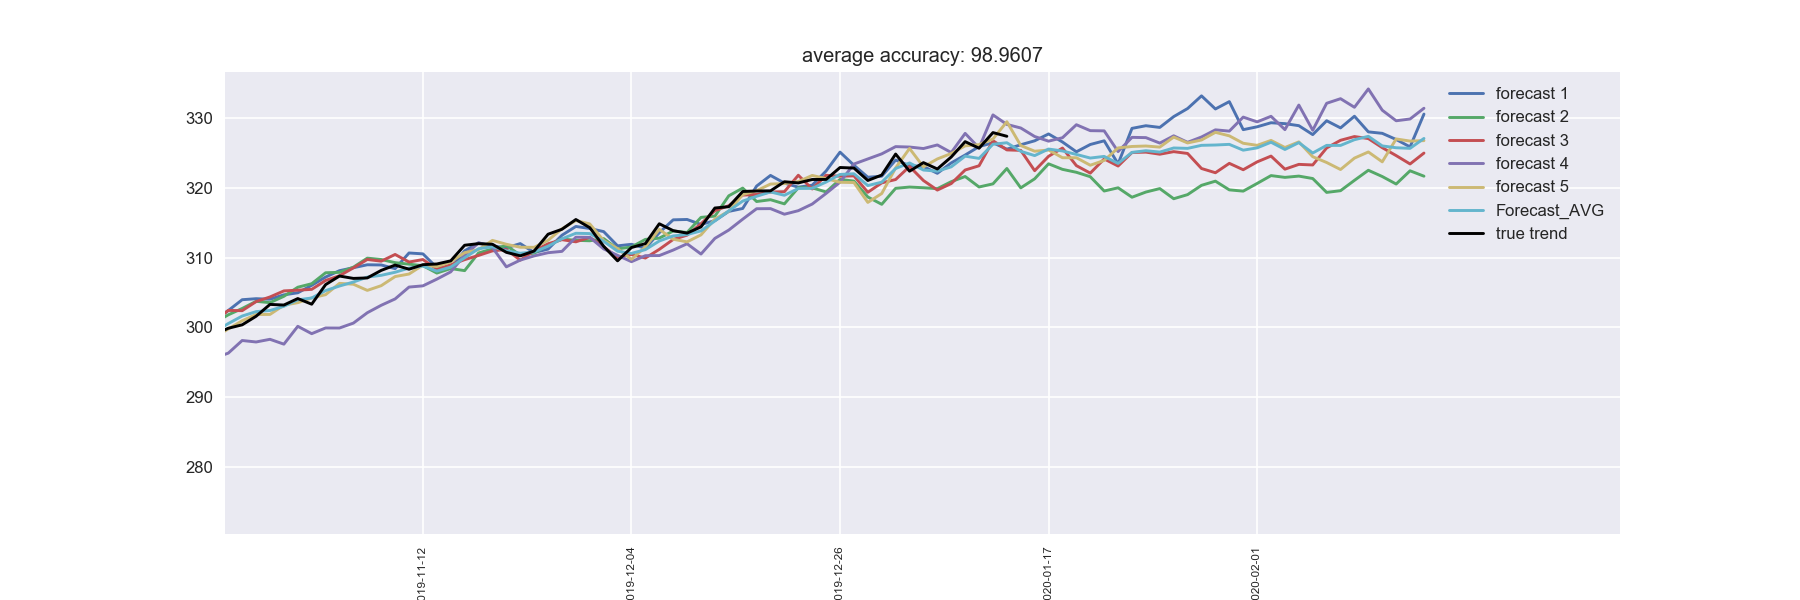

In [13]:
plt.figure(figsize=(15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label='forecast %d' % (no + 1))


plt.plot(np.mean(Fcast_avg, axis=0), label='Forecast_AVG')


plt.plot(df['Close'], label='true trend', c='black')
x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::15], date_ori[::15], fontsize=7, rotation=90)


plt.legend()
plt.title('average accuracy: %.4f' % (np.mean(accuracies)))


plt.show()

<IPython.core.display.Javascript object>


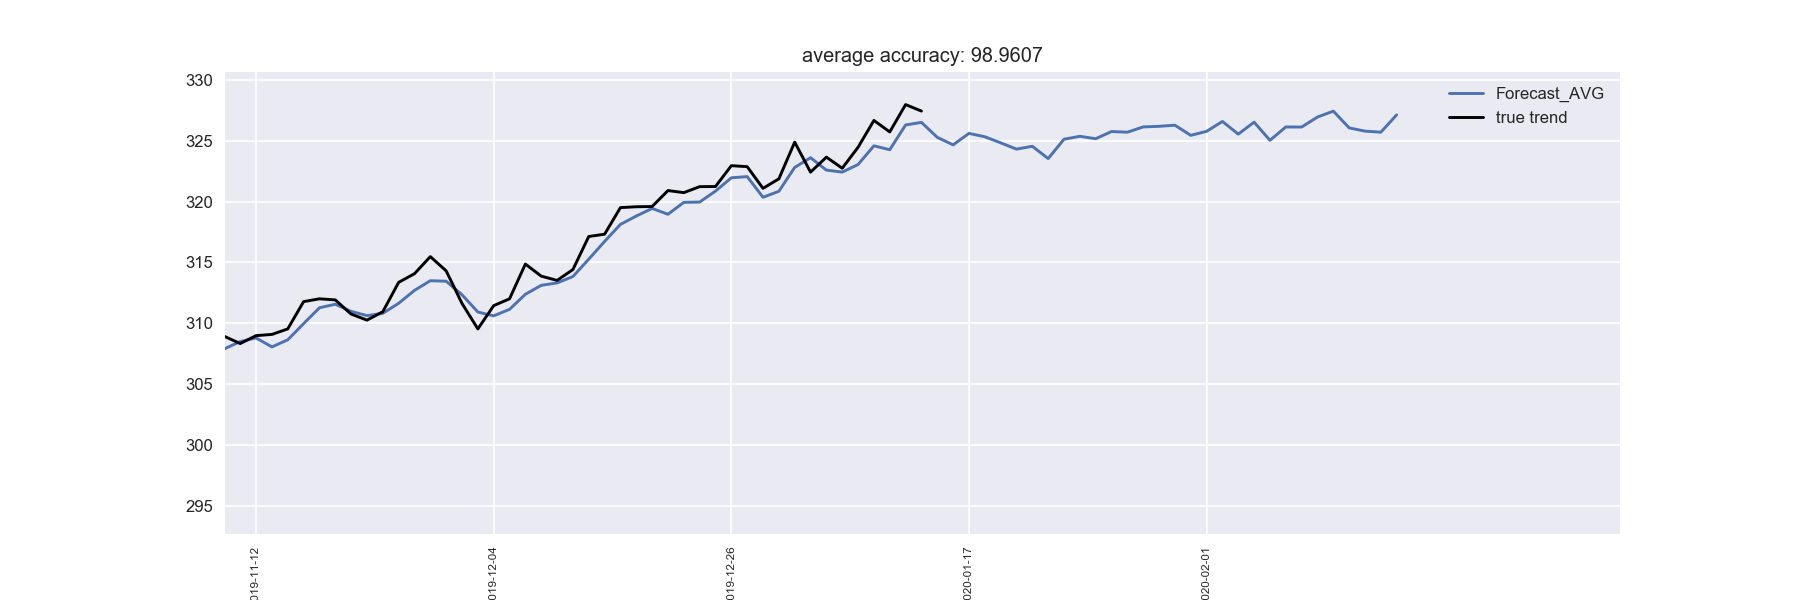

In [14]:
plt.figure(figsize=(15, 5))


plt.plot(np.mean(Fcast_avg, axis=0), label='Forecast_AVG')


plt.plot(df['Close'], label='true trend', c='black')
x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::15], date_ori[::15], fontsize=7, rotation=90)


plt.legend()
plt.title('average accuracy: %.4f' % (np.mean(accuracies)))


plt.show()